In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sklearn
import sys
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from pandas import ExcelWriter
import traitlets
from ipywidgets import widgets
from IPython.display import display
from tkinter import Tk, filedialog
import prince
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
def clean(data):

    #REMOVE DUMMY ENTRIES ***Version 3.1 Update***
    
    data = data[~data['SubCategory'].str.contains("DummyCategory")]

    #DUPLICATE USERS CHECK
    dc = data[['UserName','QuestionId']]
    dups = dc[dc.duplicated()]
    
    if(dups.empty == False):
        print('\n\n\033[1mDuplicate values in data! Check the following usernames:\033[0m')
        print(set(dups['UserName']))
        sys.exit()


    pc = data.pivot_table(index = "UserName", columns = "QuestionId", values = ["OptionNumber", "TimeTaken"])
    pc.columns.names = (None, None)

    #IMPROVED TIME TAKEN FILTER
    for user, tim in pc['TimeTaken'].iterrows():
        count = 0
        #questions = time.count()
        tim = list(tim)
        cnt = tim.count(0 or 1)
        if cnt>20: #Condition Subject to Change
            pc.drop(user, inplace=True)

    #IMPROVED SAME ASNWER CHECK
    options = list(set(data['OptionNumber']))
    for user, questions in pc['OptionNumber'].iterrows():
        thresh = 0.8*questions.count()
        for opt in options:
            cnt = list(questions).count(opt)
            if cnt>thresh:
                pc.drop(user, inplace=True)

    #PEOPLE TO KEEP
    keep = list(pc.index)

    pivot = data.pivot_table(index = "UserName", columns = ["Category", "SubCategory", "QuestionId"], values = "Marks")
    pivot.columns.names = (None, None, None)

    #KEEPING APPROVED USERS
    for user, item in pivot.iterrows():
        if user not in keep:
            pivot.drop(user, inplace= True)
            
    pivot.fillna(0, inplace=True)
    return pivot

In [3]:
def MinMax(df_old):
    heads = list(df_old.columns.levels[0])
    lvls = list(df_old.columns.levels[1])

    df_new = pd.DataFrame()
    for i in range(len(heads)):
        a = df_old[heads[i]].sum(axis=1)
        a_min = min(a)
        a_max = max(a)
        den = a_max - a_min
        a = a.apply(lambda x: (x - a_min)/den)
        a = a.to_frame()
        df_new = pd.concat([df_new, a], axis=1)

    df_new.columns = heads
    return df_new

In [35]:
def pca_results(pf):
    
    df = MinMax(pf)
    
    heads = df.columns

    noc=0

    for i in range(1, len(heads)):
        pca2 = prince.PCA(df, n_components=i)
        if pca2.cumulative_explained_inertia[i-1]>=0.7:
            noc=i
            break

    pca = PCA(n_components = noc)

    pca.fit(df)

    print("No. of components that explain >70% variance= ", noc, '\n')

    col = [x for x in range(1,noc+1)]
    lm = pca.components_.T * np.sqrt(pca.explained_variance_)
    load = pd.DataFrame(lm , index = heads, columns = col)

    print("Loadings Matrix :")
    display(load)
    
    df2 = pca2.row_principal_coordinates
    
    df2.columns = df2.columns + 1
    
    print("\n\nPrincipal Coordinates :")    
    display(df2.head())

    pca2.plot_correlation_circle()    

    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    targets = df2.index
    colors = ['r', 'g', 'b']
    ax.scatter(df2[df2.columns[0]], df2[df2.columns[1]])
    ax.grid()

    for i, txt in enumerate(list(df2.index)):
        ax.annotate(txt, (df2[df2.columns[0]].iloc[i],df2[df2.columns[1]].iloc[i]))

In [5]:
class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = list(filedialog.askopenfilename(multiple=False))

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"
        
my_button = SelectFilesButton()
my_button

SelectFilesButton(description='Select Files', icon='square-o', style=ButtonStyle(button_color='orange'))

Selected file :  Combined.xlsx 


 TEST NAME:  Know Your Uniqueness (final version) 

No. of components that explain >70% variance=  3 

Loadings Matrix :


,1,2,3
"Personality-A,",-0.121639,0.089460,-0.036825
"Personality-C,",-0.122745,0.052428,-0.105711
"Personality-E,",-0.088929,-0.182948,-0.028104
"Personality-N,",0.157690,-0.011083,-0.131748
"Personality-O,",-0.032048,-0.087225,-0.025622




Principal Coordinates :


,1,2,3
UserName,,,
B10B10,-2.249041,-0.333682,0.304630
B10B11,-1.354853,-1.240951,-1.130586
B10B12,-1.287676,-1.528484,1.739061
B10B13,1.495008,-0.193896,-0.960870
B10B14,0.181475,-1.579516,0.610827



 TEST NAME:  Find Your Passion(pilot III) 

No. of components that explain >70% variance=  2 

Loadings Matrix :


,1,2
"Interest-A,",-0.128055,0.113212
"Interest-C,",-0.126324,-0.025988
"Interest-E,",-0.154994,0.026787
"Interest-I,",-0.146123,-0.019641
"Interest-R,",-0.170900,-0.083483
"Interest-S,",-0.160001,0.011069




Principal Coordinates :


,1,2
UserName,,
B11C1,-1.869779,1.281249
B11C12,0.560328,0.629141
B11C14,-0.961294,0.077033
B11C19,-5.370724,0.915158
B11C2,3.335173,0.529520


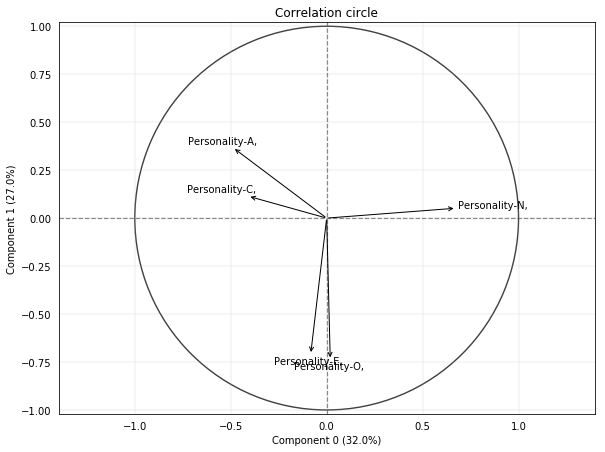

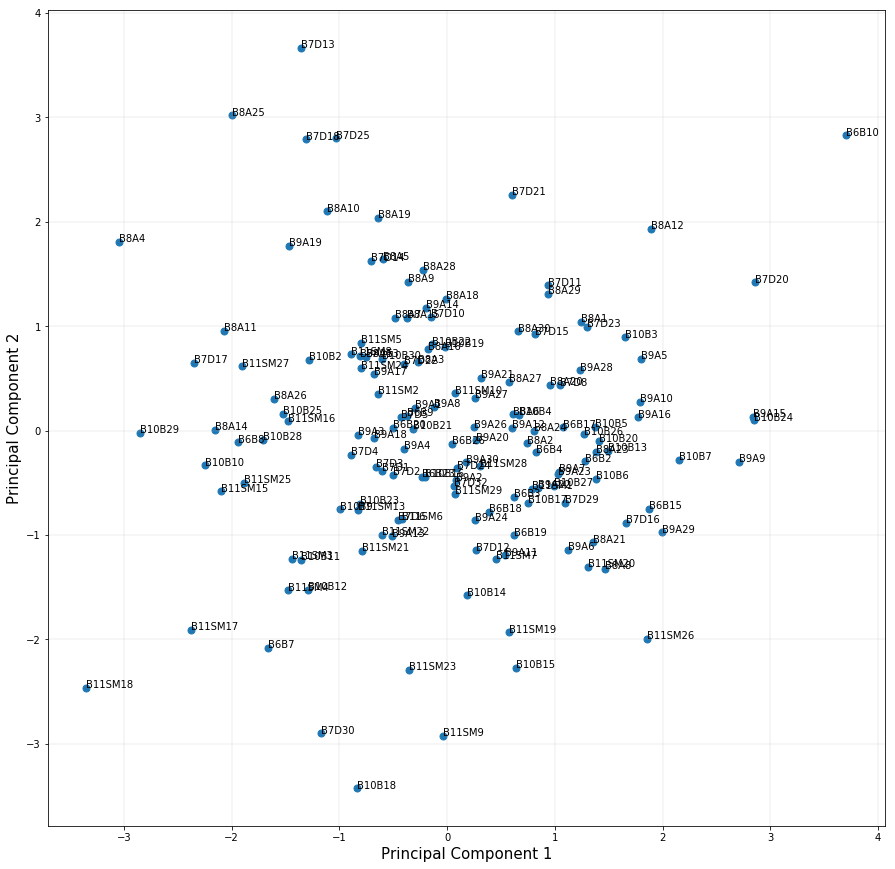

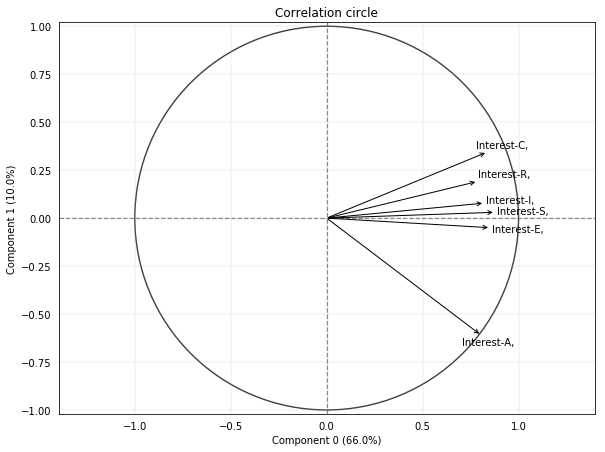

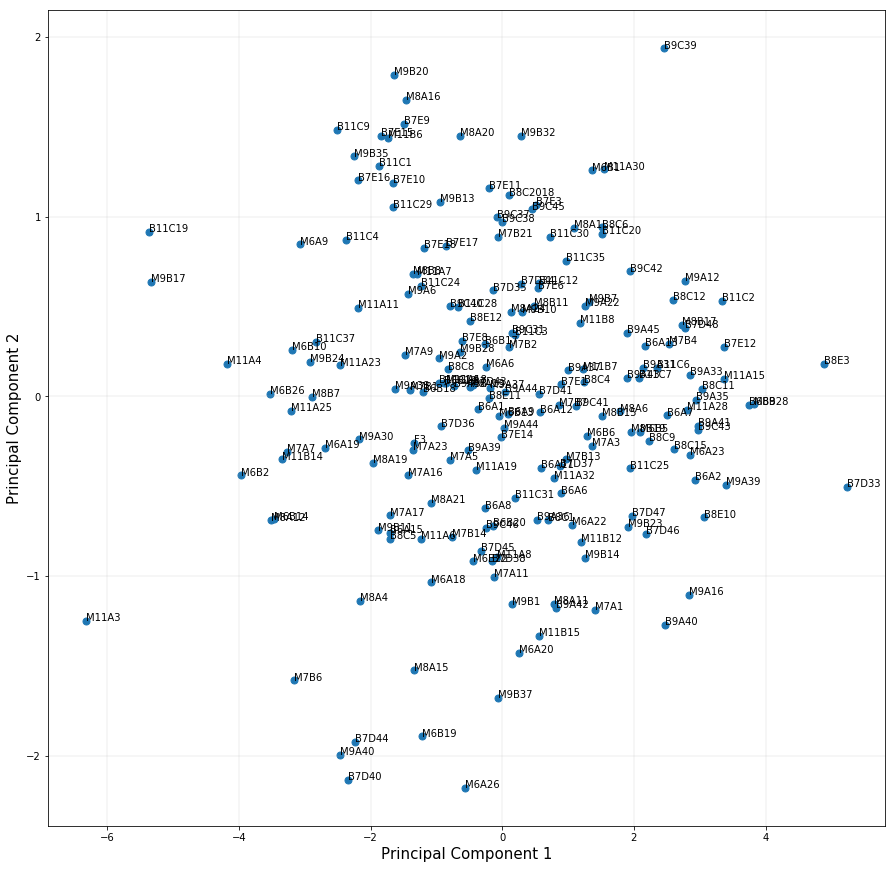

In [38]:
path = my_button.files
path = ''.join(path)

print("\033[1mSelected file : \033[0m", path.split('/')[-1], "\n")

raw = pd.read_excel(path)

tests = list(set(raw['TestName']))

for i in range(0, len(tests)):
    print("\n\033[1m TEST NAME: ", tests[i], "\033[0m\n")
    data = raw[raw['TestName'] == tests[i]]
    pivot = clean(data)
    pca_results(pivot)